In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import os
import numpy as np
import cv2
import random

new_column_names=["name","label"]

# Read the dataset and add column names
train_ds = pd.read_csv("/kaggle/input/machathon-3/train_labels.csv")
train_ds = train_ds.rename(columns=dict(zip(train_ds.columns, new_column_names)))

# Display the first few rows of the DataFrame
train_ds.head(10)

,name,label
0,00000.jpg,اظش029
1,00001.jpg,لل1
2,00002.jpg,ثصش55
3,00003.jpg,ثغد252
4,00004.jpg,شفب334
5,00005.jpg,تت1061
6,00006.jpg,غعم2
7,00007.jpg,سغذ1739
8,00008.jpg,خكت76
9,00009.jpg,فهق19


# Constants

In [2]:
import string

# Original mapping from class_name to English letters
original_mapping = {
    "1": "1", "6": "6", "5": "5", "4": "4", "7": "7", "9": "9", "3": "3", "2": "2", "8": "8",
    "meem": "م", "0": "0", "raa": "ر", "seen": "س", "alif": "ا", "daal": "د", "noon": "ن",
    "waw": "و", "ain": "ع", "haa": "ه", "laam": "ل", "jeem": "ج", "baa": "ب", "qaaf": "ق",
    "yaa": "ى", "faa": "ف", "Taa": "ط", "saad": "ص", "thaa": "ث", "ghayn": "ج", "sheen": "ش",
    "Thaa": "ظ", "khaa": "خ", "kaaf": "ك", "taa": "ت", "zay": "ز", "zaal": "ذ", "7aa": "ح",
    "daad": "ض"
}

# Arabic to English mapping
ar_to_en = {
    "١": "1", "٢": "2", "٣": "3", "٤": "4", "٥": "5", "٦": "6", "٧": "7", "٨": "8", "٩": "9", "٠": "0",
    "ا": "A", "ب": "B", "ت": "C", "ث": "D", "ج": "E", "ح": "F", "خ": "G", "د": "H", "ذ": "I",
    "ر": "J", "ز": "K", "س": "L", "ش": "M", "ص": "N", "ض": "O", "ط": "P", "ظ": "Q", "ع": "R", "غ": "S",
    "ف": "T", "ق": "U", "ك": "V", "ل": "W", "م": "n", "ن": "Y", "ه": "Z", "و": "a", "ى": "b",
    "1": "1", "2": "2", "3": "3", "4": "4", "5": "5", "6": "6", "7": "7", "8": "8", "9": "9", "0": "0"
}

en_to_ar = {v: k for k, v in ar_to_en.items()}

# Remove duplicate values to get unique letters
unique_letters = sorted(set(ar_to_en.values()))

# Add 'X' as the padding character
unique_letters.append('X')

# Convert the unique letters list to a string
CHAR_VECTOR = ''.join(unique_letters)

# Create a list of letters
letters = [letter for letter in CHAR_VECTOR]

num_classes = len(letters) + 1

img_w, img_h = 128, 64

# Network parameters
batch_size = 8
val_batch_size = 1

downsample_factor = 4
max_text_len = 7

print(CHAR_VECTOR)


0123456789ABCDEFGHIJKLMNOPQRSTUVWYZabnX


In [3]:
def preprocess_label(label):
    # Reverse the text
    reversed_label = label[::-1]
    new_label = ""
    for letter in reversed_label:
        if letter in ar_to_en:
            new_label += ar_to_en[letter]
        else:
            continue
    # Add "X" to complete 7 letters
    new_label += "X" * (7 - len(new_label))
    return new_label

# Apply preprocessing to the dataset
train_ds['label'] = train_ds['label'].apply(preprocess_label)

# Save the preprocessed dataset
train_ds.to_csv("new_train.csv", index=False)


In [4]:
train_ds.head()

,name,label
0,00000.jpg,920MQAX
1,00001.jpg,1WWXXXX
2,00002.jpg,55MNDXX
3,00003.jpg,252HSDX
4,00004.jpg,433BTMX


## Create Validation data

In [5]:
# Define the column names
column_names = ["name", "x1", "y1", "x2", "y2", "class_name"]

# Read the dataset and add column names
train_ds2= pd.read_csv("/kaggle/input/egyptian-car-plates/train/_annotations.csv", names=column_names)
valid_ds=pd.read_csv("/kaggle/input/egyptian-car-plates/valid/_annotations.csv", names=column_names)
test_ds = pd.read_csv("/kaggle/input/egyptian-car-plates/test/_annotations.csv", names=column_names)

In [6]:
import pandas as pd

def convert_and_save(df, output_file):
   

    # Apply original mapping and Arabic to English mapping to class_name
    df["class_name"] = df["class_name"].replace(original_mapping).replace(ar_to_en)

    # Group by filepath and aggregate other columns
    df_grouped = df.groupby("name").agg({"x1": list, "y1": list, "x2": list, "y2": list, "class_name": ''.join}).reset_index()

    # Combine the x1, y1, x2, y2 lists into a single string
    df_grouped["coordinates"] = df_grouped.apply(lambda row: ' '.join(map(str, row[['x1', 'y1', 'x2', 'y2']].values.flatten())), axis=1)

    # Drop the unnecessary columns
    df_grouped.drop(columns=['x1', 'y1', 'x2', 'y2'], inplace=True)

    # Reverse the combined text and remove spaces
    df_grouped["class_name"] = df_grouped["class_name"].apply(lambda x: ''.join(reversed(x.strip().replace(" ", ""))))

    # Add "X" to make sure each label is 7 characters long
    df_grouped["class_name"] = df_grouped["class_name"].apply(lambda x: x.ljust(7, 'X'))

    # Create a new column for the label formatted as numbers followed by letters
    df_grouped["label"] = df_grouped["class_name"].apply(lambda x: ''.join([char if char.isdigit() else ' ' + char for char in x]).strip())
    # Remove spaces from the label
    df_grouped["label"] = df_grouped["label"].str.replace(" ", "")
    # Save the result to a new CSV file
    df_grouped[["name", "label"]].to_csv(output_file, index=False)

    print("Conversion completed!")

  
convert_and_save(train_ds2, "train_ds2.csv")
train_ds2= pd.read_csv("train_ds2.csv")
convert_and_save(valid_ds, "valid_ds.csv")
valid_ds= pd.read_csv("valid_ds.csv")
convert_and_save(test_ds, "test_ds.csv")
test_ds = pd.read_csv("test_ds.csv")


Conversion completed!
Conversion completed!
Conversion completed!


In [7]:
import os
import shutil
import pandas as pd

# Function to merge CSV datasets and copy images into a single folder
def merge_and_copy_datasets(csv_paths, img_paths, output_path):
    # Merge DataFrames from all CSV paths
    merged_csv = pd.concat([pd.read_csv(csv_path) for csv_path in csv_paths], ignore_index=True)
    
    # Create output folder for merged dataset
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Copy images from each image path to the output folder
    for img_path in img_paths:
        for filename in os.listdir(img_path):
            src_path = os.path.join(img_path, filename)
            dest_path = os.path.join(output_path, filename)
            if os.path.isfile(src_path):
                shutil.copy(src_path, dest_path)

    # Save merged CSV
    merged_csv_path = os.path.join(output_path, 'merged_data.csv')
    merged_csv.to_csv(merged_csv_path, index=False)

    return merged_csv_path

# Paths to the CSV files and image directories
csv_paths = [
    "/kaggle/working/new_train.csv",  # Path to the first CSV
    "/kaggle/working/train_ds2.csv",  # Path to the second CSV
   "/kaggle/working/valid_ds.csv",  # Path to the third CSV
    "/kaggle/working/test_ds.csv"   # Path to the fourth CSV
]

img_paths = [
    "/kaggle/input/machathon-3/train_images/",  # Path to the first image directory
    "/kaggle/input/egyptian-car-plates/train/",  # Path to the second image directory
    "/kaggle/input/egyptian-car-plates/valid/",  # Path to the third image directory
    "/kaggle/input/egyptian-car-plates/test/"   # Path to the fourth image directory
]

output_path = '/kaggle/working/merged_train/'  # Path to the output directory

# Execute the function
merged_csv_path = merge_and_copy_datasets(csv_paths, img_paths, output_path)

# Load and display the merged CSV
train_ds = pd.read_csv(merged_csv_path)
train_ds.head()


,name,label
0,00000.jpg,920MQAX
1,00001.jpg,1WWXXXX
2,00002.jpg,55MNDXX
3,00003.jpg,252HSDX
4,00004.jpg,433BTMX


In [8]:
def labels_to_text(labels):     
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [9]:
class DataImageGenerator:
    def __init__(self, img_dirpath,df, img_w, img_h,
                 batch_size, downsample_factor, max_text_len=7):
        self.img_h = img_h
        self.img_w = img_w
        self.df = df
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        self.img_dirpath = img_dirpath                  # image dir path
        self.img_dir = os.listdir(self.img_dirpath)     # images list
        self.n = self.df.shape[0]                      # number of images
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []


    def build_data(self, df):
        img_names = self.df['name'].values
        labels = self.df['label'].values
        print(self.n, " Image Loading start...")
        for i in range(len(img_names)):
            img = cv2.imread(self.img_dirpath + img_names[i], cv2.IMREAD_GRAYSCALE)
    
            try:
                img = cv2.resize(img, (self.img_w, self.img_h))
                img = img.astype(np.float32)
            except:
                print(self.img_dirpath + img_names[i])
                exit()

            img = (img/255.0)
            
            self.imgs[i, :, :] = img
            self.texts.append(labels[i])
        print(len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")
        print(self.texts)

    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):       ## batch size
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])     # (bs, 128, 64, 1)
            Y_data = np.ones([self.batch_size, self.max_text_len])             # (bs, 9)
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)  # (bs, 1)
            label_length = np.zeros((self.batch_size, 1))           # (bs, 1)

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                label_length[i] = len(text)

            inputs = {
                'the_input': X_data,  # (bs, 128, 64, 1)
                'the_labels': Y_data,  # (bs, 8)
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])} 
            yield (inputs, outputs)

In [10]:
from sklearn.model_selection import train_test_split

train_ds, valid_ds = train_test_split(train_ds, test_size=0.2, random_state=42)

In [11]:
train_file_path = '/kaggle/working/merged_train/'
ds_train = DataImageGenerator(train_file_path, train_ds,img_w, img_h, batch_size, downsample_factor)
ds_train.build_data(train_ds)

7200  Image Loading start...
True
7200  Image Loading finish...
['0WNXXXX', '9YLXXXX', '1111YEX', '7357WAI', '2222Ann', '196aPXX', '1YPaXXX', '642AJDX', '9InXXXX', '20aVXXX', '4444nEY', '221SbKX', '840LOXX', '424ZYXX', '410bnDX', '1111BaX', '0738YEV', '1nRXXXX', '1ZXXXXX', '9955DOF', '7445nNP', '555YaEX', '284OOXX', '1HIXXXX', '31OJMXX', '381NOXX', '29OPWXX', '989YPXX', '1993nnn', '86DVXXX', '5789HWL', '666UWPX', '0295DFn', '222UUUX', '1HLAXXX', '068CVIX', '866TbXX', '6666bbX', '5839NDX', '4FYXXXX', '9HHNXXX', '755URHX', '52YnZXX', '914bDHX', '444RWHX', '111JNnX', '5512BDX', '753AAHX', '881ACXX', '970nLXX', '3333nAZ', '215DUEX', '1873BNX', '4444TTX', '219aIOX', '2KaXXXX', '03ARXXX', '5555YbK', '111BEJX', '79RUXXX', '1111bWY', '7529JIC', '028QEXX', '8234CLX', '86MVUXX', '448IAFX', '5065GFO', '1JVXXXX', '5302EYT', '19EEGXX', '8155MUX', '204WTXX', '157FZXX', '8bUXXXX', '7822IbK', '74YUXXX', '5YGXXXX', '95aYXXX', '57MWXXX', '4597DQb', '7UAXXXX', '57QUHXX', '722FRXX', '40LTXXX', '5794GRB', 

In [12]:
valid_file_path = '/kaggle/working/merged_train/'
ds_valid = DataImageGenerator(valid_file_path, valid_ds,img_w, img_h, batch_size, downsample_factor)
ds_valid.build_data(valid_ds)

1801  Image Loading start...
True
1801  Image Loading finish...
['02FZQXX', '14TORXX', '64YRXXX', '1PUYXXX', '8111EbX', '02RTPXX', '6EnZXXX', '2222aYZ', '6FbXXXX', '51EbXXX', '6STXXXX', '0QIXXXX', '3EQXXXX', '066CEDX', '6666AEY', '8nYaXXX', '806DSIX', '5RaFXXX', '160aULX', '1111aEX', '01QUGXX', '00TLXXX', '1ZnXXXX', '6CJXXXX', '84YIaXX', '9JVXXXX', '4ZYXXXX', '7804WEE', '046NnTX', '1anXXXX', '8937IBK', '9BMTXXX', '601ERXX', '0283SLE', '5727GAX', '4HEXXXX', '7YnXXXX', '4443RJX', '89HRUXX', '089nRXX', '5174JOE', '3851LEX', '424abIX', '2883UbX', '6MMXXXX', '71GCXXX', '2BIHXXX', '3NnEXXX', '0004AEX', '33KQXXX', '1bQGXXX', '4WZXXXX', '8EUXXXX', '7925YaX', '198EHSX', '7027KbX', '104SaRX', '7562GSb', '885KMXX', '23YGXXX', '7777JJJ', '05aQXXX', '662UbbX', '761GGXX', '217RHXX', '0FEYXXX', '5832EPY', '4958UAA', '1111bUT', '91MIFXX', '777JUNX', '2WEGXXX', '8AXXXXX', '2414CCJ', '1FFXXXX', '7256FVF', '62nRXXX', '670GROX', '4444HLA', '70NTPXX', '460JDXX', '495LYXX', '910BPXX', '6651UPJ', '970BWJX', 

# Model Layers

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Reshape, Lambda
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import add, concatenate


# VGG Blocks
class VggBlock1(keras.layers.Layer):
    def __init__(self, num_filters, do_maxpool: bool = True, **kwargs):
        super(VggBlock1, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.do_maxpool = do_maxpool
        self.conv = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn = BatchNormalization()
        self.relu = Activation("relu")
        if self.do_maxpool:
            self.pool = MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        if self.do_maxpool:
            x = self.pool(x)
        return x

    def get_config(self):
        config = super(VggBlock1, self).get_config()
        config.update({
            'num_filters': self.num_filters,
            'do_maxpool': self.do_maxpool
        })
        return config


class VggBlock2(keras.layers.Layer):
    def __init__(self, num_filters, **kwargs):
        super(VggBlock2, self).__init__(**kwargs)
        self.num_filters = num_filters
        
        self.conv1 = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn1 = BatchNormalization()
        self.relu1 = Activation("relu")
        self.conv2 = Conv2D(
            num_filters, (3, 3), padding="same", kernel_initializer="he_normal"
        )
        self.bn2 = BatchNormalization()
        self.relu2 = Activation("relu")
        self.pool = MaxPooling2D(pool_size=(1, 2))

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        return x
    
    def get_config(self):
        config = super(VggBlock2, self).get_config()
        config.update({"num_filters": self.num_filters})
        return config



# RNN
class BI_LSTM_Block(keras.layers.Layer):
    def __init__(self, num_units, merge_mode, **kwargs):
        super(BI_LSTM_Block, self).__init__(**kwargs)
        self.num_units = num_units
        self.merge_mode = merge_mode

        self.bi_lstm = Bidirectional(
            LSTM(num_units, return_sequences=True, kernel_initializer="he_normal"),
            merge_mode=merge_mode,
        )
        self.bn = BatchNormalization()

    def call(self, inputs):
        x = self.bi_lstm(inputs)
        x = self.bn(x)
        return x

    def get_config(self):
        config = super(BI_LSTM_Block, self).get_config()
        config.update({"num_units": self.num_units, "merge_mode": self.merge_mode})
        return config



def ctc_lamda_func(args):
    y_pred, labels, input_length, label_length = args

    y_pred = y_pred[:, 2:, :]
    return keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


def build_model(training):

    input_shape = (128, 64, 1)

    inputs = Input(name="the_input", shape=input_shape, dtype="float32")

    # VGG (CNN)
    x = VggBlock1(64, name="VGG_Block1")(inputs)
    x = VggBlock1(128, name="VGG_Block2")(x)
    x = VggBlock2(256, name="VGG_Block3")(x)
    x = VggBlock2(512, name="VGG_Block4")(x)
    x = VggBlock1(512, do_maxpool=False, name="VGG_Block5")(x)

    # CNN to RNN
    new_shape = (32, 2048)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", kernel_initializer="he_normal", name="dense1")(x)

    # RNN
    x = BI_LSTM_Block(256, merge_mode="sum", name="BI_LSTM_Block1")(x)
    x = BI_LSTM_Block(128, merge_mode="concat", name="BI_LSTM_Block2")(x)

    x = Dropout(0.25)(x)

    # RNN output to character activations
    x = Dense(num_classes, kernel_initializer="he_normal", name="dense2")(x)
    y_pred = Activation("softmax", name="softmax")(x)

    labels = Input(name="the_labels", shape=[max_text_len], dtype="float32")
    input_length = Input(name="input_length", shape=[1], dtype="int64")
    label_length = Input(name="label_length", shape=[1], dtype="int64")

    loss_out = Lambda(ctc_lamda_func, output_shape=(1,), name="ctc")(
        [y_pred, labels, input_length, label_length]
    )

    if training:
        return keras.Model(
            inputs=[inputs, labels, input_length, label_length], outputs=loss_out
        )
    else:
        return keras.Model(inputs=[inputs], outputs=y_pred)


# Callbacks

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_ad_best.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [15]:
model = build_model(True)
opt = tf.keras.optimizers.Adadelta(1.0)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, metrics=['accuracy'], optimizer=opt)
     

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
VGG_Block1 (VggBlock1)          (None, 64, 32, 64)   896         the_input[0][0]                  
__________________________________________________________________________________________________
VGG_Block2 (VggBlock1)          (None, 32, 16, 128)  74368       VGG_Block1[0][0]                 
__________________________________________________________________________________________________
VGG_Block3 (VggBlock2)          (None, 32, 8, 256)   887296      VGG_Block2[0][0]                 
______________________________________________________________________________________________

In [17]:
batch_size = 8
history = model.fit(
    ds_train.next_batch(),
    steps_per_epoch=int(ds_train.n / batch_size),
    epochs=200,
    callbacks=[early_stopping, model_checkpoint],  
    validation_data=ds_valid.next_batch(),  
    validation_steps=int(ds_valid.n / batch_size)
)


Epoch 1/200
900/900 [==============================] - 46s 35ms/step - loss: 25.6677 - accuracy: 0.0000e+00 - val_loss: 17.2583 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 17.25826, saving model to model_ad_best.keras
Epoch 2/200
900/900 [==============================] - 29s 33ms/step - loss: 9.5923 - accuracy: 1.3889e-04 - val_loss: 5.4297 - val_accuracy: 5.5556e-04

Epoch 00002: val_loss improved from 17.25826 to 5.42970, saving model to model_ad_best.keras
Epoch 3/200
900/900 [==============================] - 29s 33ms/step - loss: 3.3551 - accuracy: 0.0789 - val_loss: 2.5098 - val_accuracy: 0.2744

Epoch 00003: val_loss improved from 5.42970 to 2.50980, saving model to model_ad_best.keras
Epoch 4/200
900/900 [==============================] - 30s 33ms/step - loss: 1.8544 - accuracy: 0.4174 - val_loss: 1.9864 - val_accuracy: 0.4650

Epoch 00004: val_loss improved from 2.50980 to 1.98642, saving model to model_ad_best.keras
Epoch 5/200
900/900 [===========

In [18]:
model.save_weights("model_ad_best.weights.h5")

In [19]:
!pip install plot_keras_history
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
     

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 322 kB 3.9 MB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9472 sha256=63bd1e548a0d0d5a48d73874eedab731e6e3e1f1e9c9abe7aa55e2a7aa372dd2
  Stored in directory: /root/.cache/pip/wheels/f1/91/1c/bdba9dfd430fdabe38c1077da71de189658be21716be91d184
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321878 sha256=779ceb4e029fcd8f069fce2558e8e5eda814bbfc407ecf0e071ec0ab32a6bc36
  Stored in directory: /root/.cache/pip/wheels/eb/57/f6/19f30c11b68294befbca317f5e347b8ec832ed4c5d34da8006
  Created wheel for support-developer: filename=support_developer-1.0.5-py3-none-any.whl size=5652 sha256=f35ca2cbde1c6f689d9fdccd38d92fa61e8d2ac73e68b2dd905b9b710c59224b
  Stored in direc

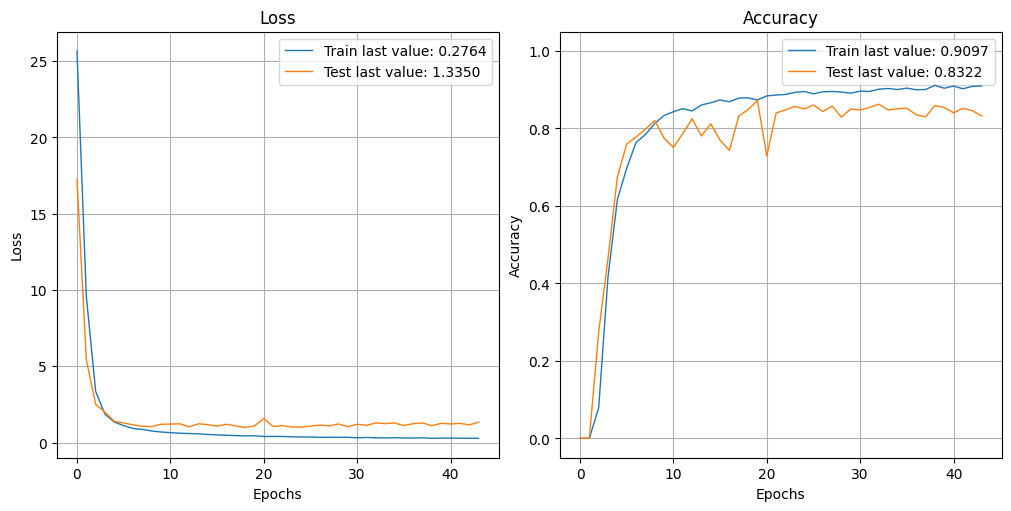

In [20]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

# Prediction

In [21]:
import cv2
import itertools, os, time
import numpy as np
import argparse
import pandas as pd
import operator
import os

In [22]:
# Function to convert label to English
def label_to_en(label):
    new = ""
    for l in label:
        if l == " ":
            continue
        elif l in string.digits:
            new += l
        else:
            try:
                new = new + ar_to_en[l]
            except:
                continue
    
    missing = max_letters - len(new)
    if missing > 0:
        new = new + "X" * missing
    return new

# Function to reverse a string
def reverse_str(s):
    return s[::-1]

# Function to convert label to Arabic
def label_to_ar(label):
    label = reverse_str(label)
    ar_label = ""
    for i in label:
        if i == "X":
            continue
        else:
            ar_label += en_to_ar[i] + " "
    ar_label = ar_label.strip()
    return ar_label

# Function to get label from indexes
def get_label(idxes):
    label = ""
    for idx in idxes:
        if idx < len(letters):
            label += letters[idx]
    return label

# Function to decode label
def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))
    out_best = [k for k, g in itertools.groupby(out_best)]
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

In [23]:
import os
import pandas as pd

def predict_and_submit(model, test_images_folder, output_csv_file):
    predictions_df = pd.DataFrame(columns=['img_name', 'label'])

    start = time.time()
    for img_name in os.listdir(test_images_folder):
        img_path = os.path.join(test_images_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img_pred = img.astype(np.float32)
        img_pred = cv2.resize(img_pred, (128, 64))
        img_pred = (img_pred / 255.0)
        img_pred = img_pred.T
        img_pred = np.expand_dims(img_pred, axis=-1)
        img_pred = np.expand_dims(img_pred, axis=0)

        net_out_value = model.predict(img_pred, verbose=1)
        pred_text = decode_label(net_out_value)
        pred_text_ar = label_to_ar(pred_text)
        
        predictions_df = predictions_df.append({'img_name': img_name, 'label': ''.join(pred_text_ar).replace(" ", "")}, ignore_index=True)

        
        print(f"Predicted label for {img_name}: {pred_text_ar}")
        
    predictions_df.to_csv(output_csv_file, index=False)

    end = time.time()
    print(f"Time taken: {end - start:.2f} seconds")


# Get RCNN model
model = build_model(False)
try:
        model.load_weights("model_ad_best.weights.h5")
        print("...Previous weight data...")
except:
        raise Exception("No weight file!")
test_images_folder = "/kaggle/input/machathon-3/test_images/"
output_csv_file = "submission.csv"

predict_and_submit(model, test_images_folder, output_csv_file)


...Previous weight data...
1/1 [==============================] - 2s 2s/step
Predicted label for 00266.jpg: ب ه ى 1
1/1 [==============================] - 0s 28ms/step
Predicted label for 00614.jpg: ه ا م 4 5 5
1/1 [==============================] - 0s 29ms/step
Predicted label for 00091.jpg: ص ق ر 7 7 7 8
1/1 [==============================] - 0s 25ms/step
Predicted label for 00296.jpg: ر ق م 9
1/1 [==============================] - 0s 24ms/step
Predicted label for 00219.jpg: خ ن ى 8 8 1
1/1 [==============================] - 0s 22ms/step
Predicted label for 00130.jpg: ج ج ج 2 2 2 2
1/1 [==============================] - 0s 23ms/step
Predicted label for 00460.jpg: ج ب ل 8 8 8 8
1/1 [==============================] - 0s 21ms/step
Predicted label for 00254.jpg: ف و د 5 5 5
1/1 [==============================] - 0s 22ms/step
Predicted label for 00160.jpg: ى ر 4 4 4 4
1/1 [==============================] - 0s 23ms/step
Predicted label for 00109.jpg: ع 2 2 1
1/1 [==========================